# submission-level analysis

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import sqlite3
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
from itertools import combinations
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from utils import *

## load data

In [2]:
df2012 = build_df_year(2012, with_text=True, with_time=True, filter_null=False)
generate_index()

from utils import USERS, SUBREDDITS, user2index, index2user, subr2index, index2subr

building base dataframe for year 2012...
- fetching submissions for year 2012
- fetching comments for year 2012
- number of entries: 6935046


In [3]:
df2012["body_len"] = df2012["body"].map(lambda x: len(x))

## aggregate by submission

In [4]:
# aggregate by submission
aggr_func = {"comment_id": lambda x: list(x), "toxicity": np.mean, "body_len":np.sum}
groupby_subm = df2012.groupby("submission_id").agg(aggr_func).reset_index()
groupby_subm["n_comments"] = groupby_subm["comment_id"].map(lambda x: len(x))

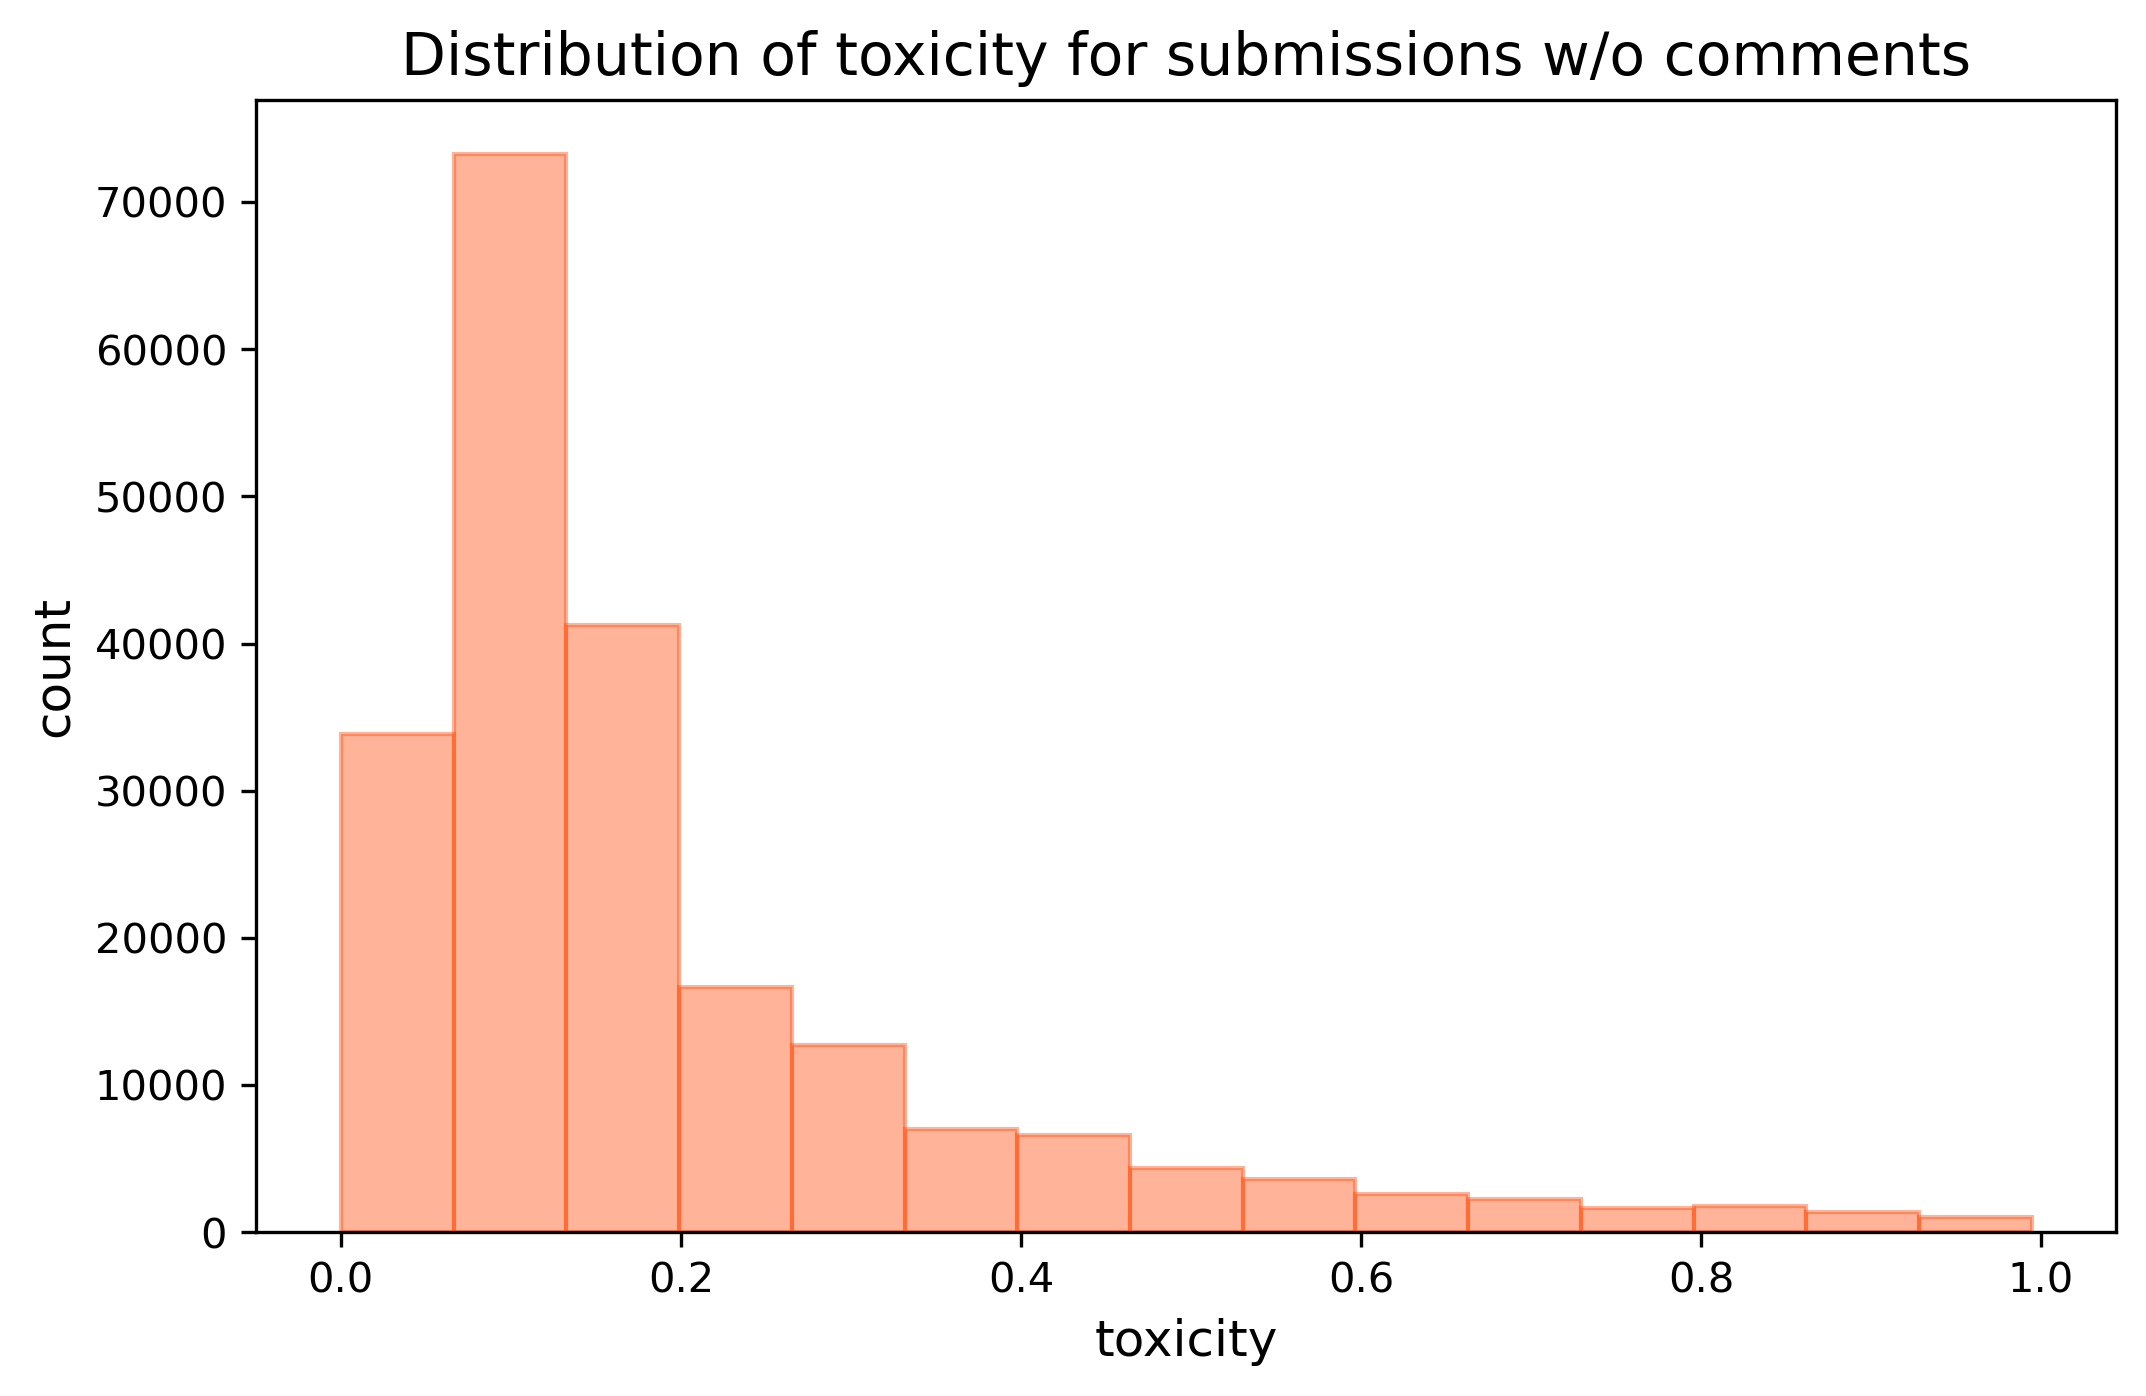

In [8]:
# toxicity score for submissions that have no comment
no_comment_subm = groupby_subm[groupby_subm["n_comments"]==1]
fig,ax = plt.subplots(figsize=(8,5),dpi=300)
plt.hist(no_comment_subm["toxicity"], bins=15, color="#FF4500", ec="#FF4500", alpha=0.4)
plt.xlabel("toxicity", fontsize=12)
plt.ylabel("count", fontsize=12)
plt.title("Distribution of toxicity for submissions w/o comments", fontsize=14)
plt.savefig(ROOTPATH + "output/fig/toxicity_distr_subm0comm.png", dpi=300)

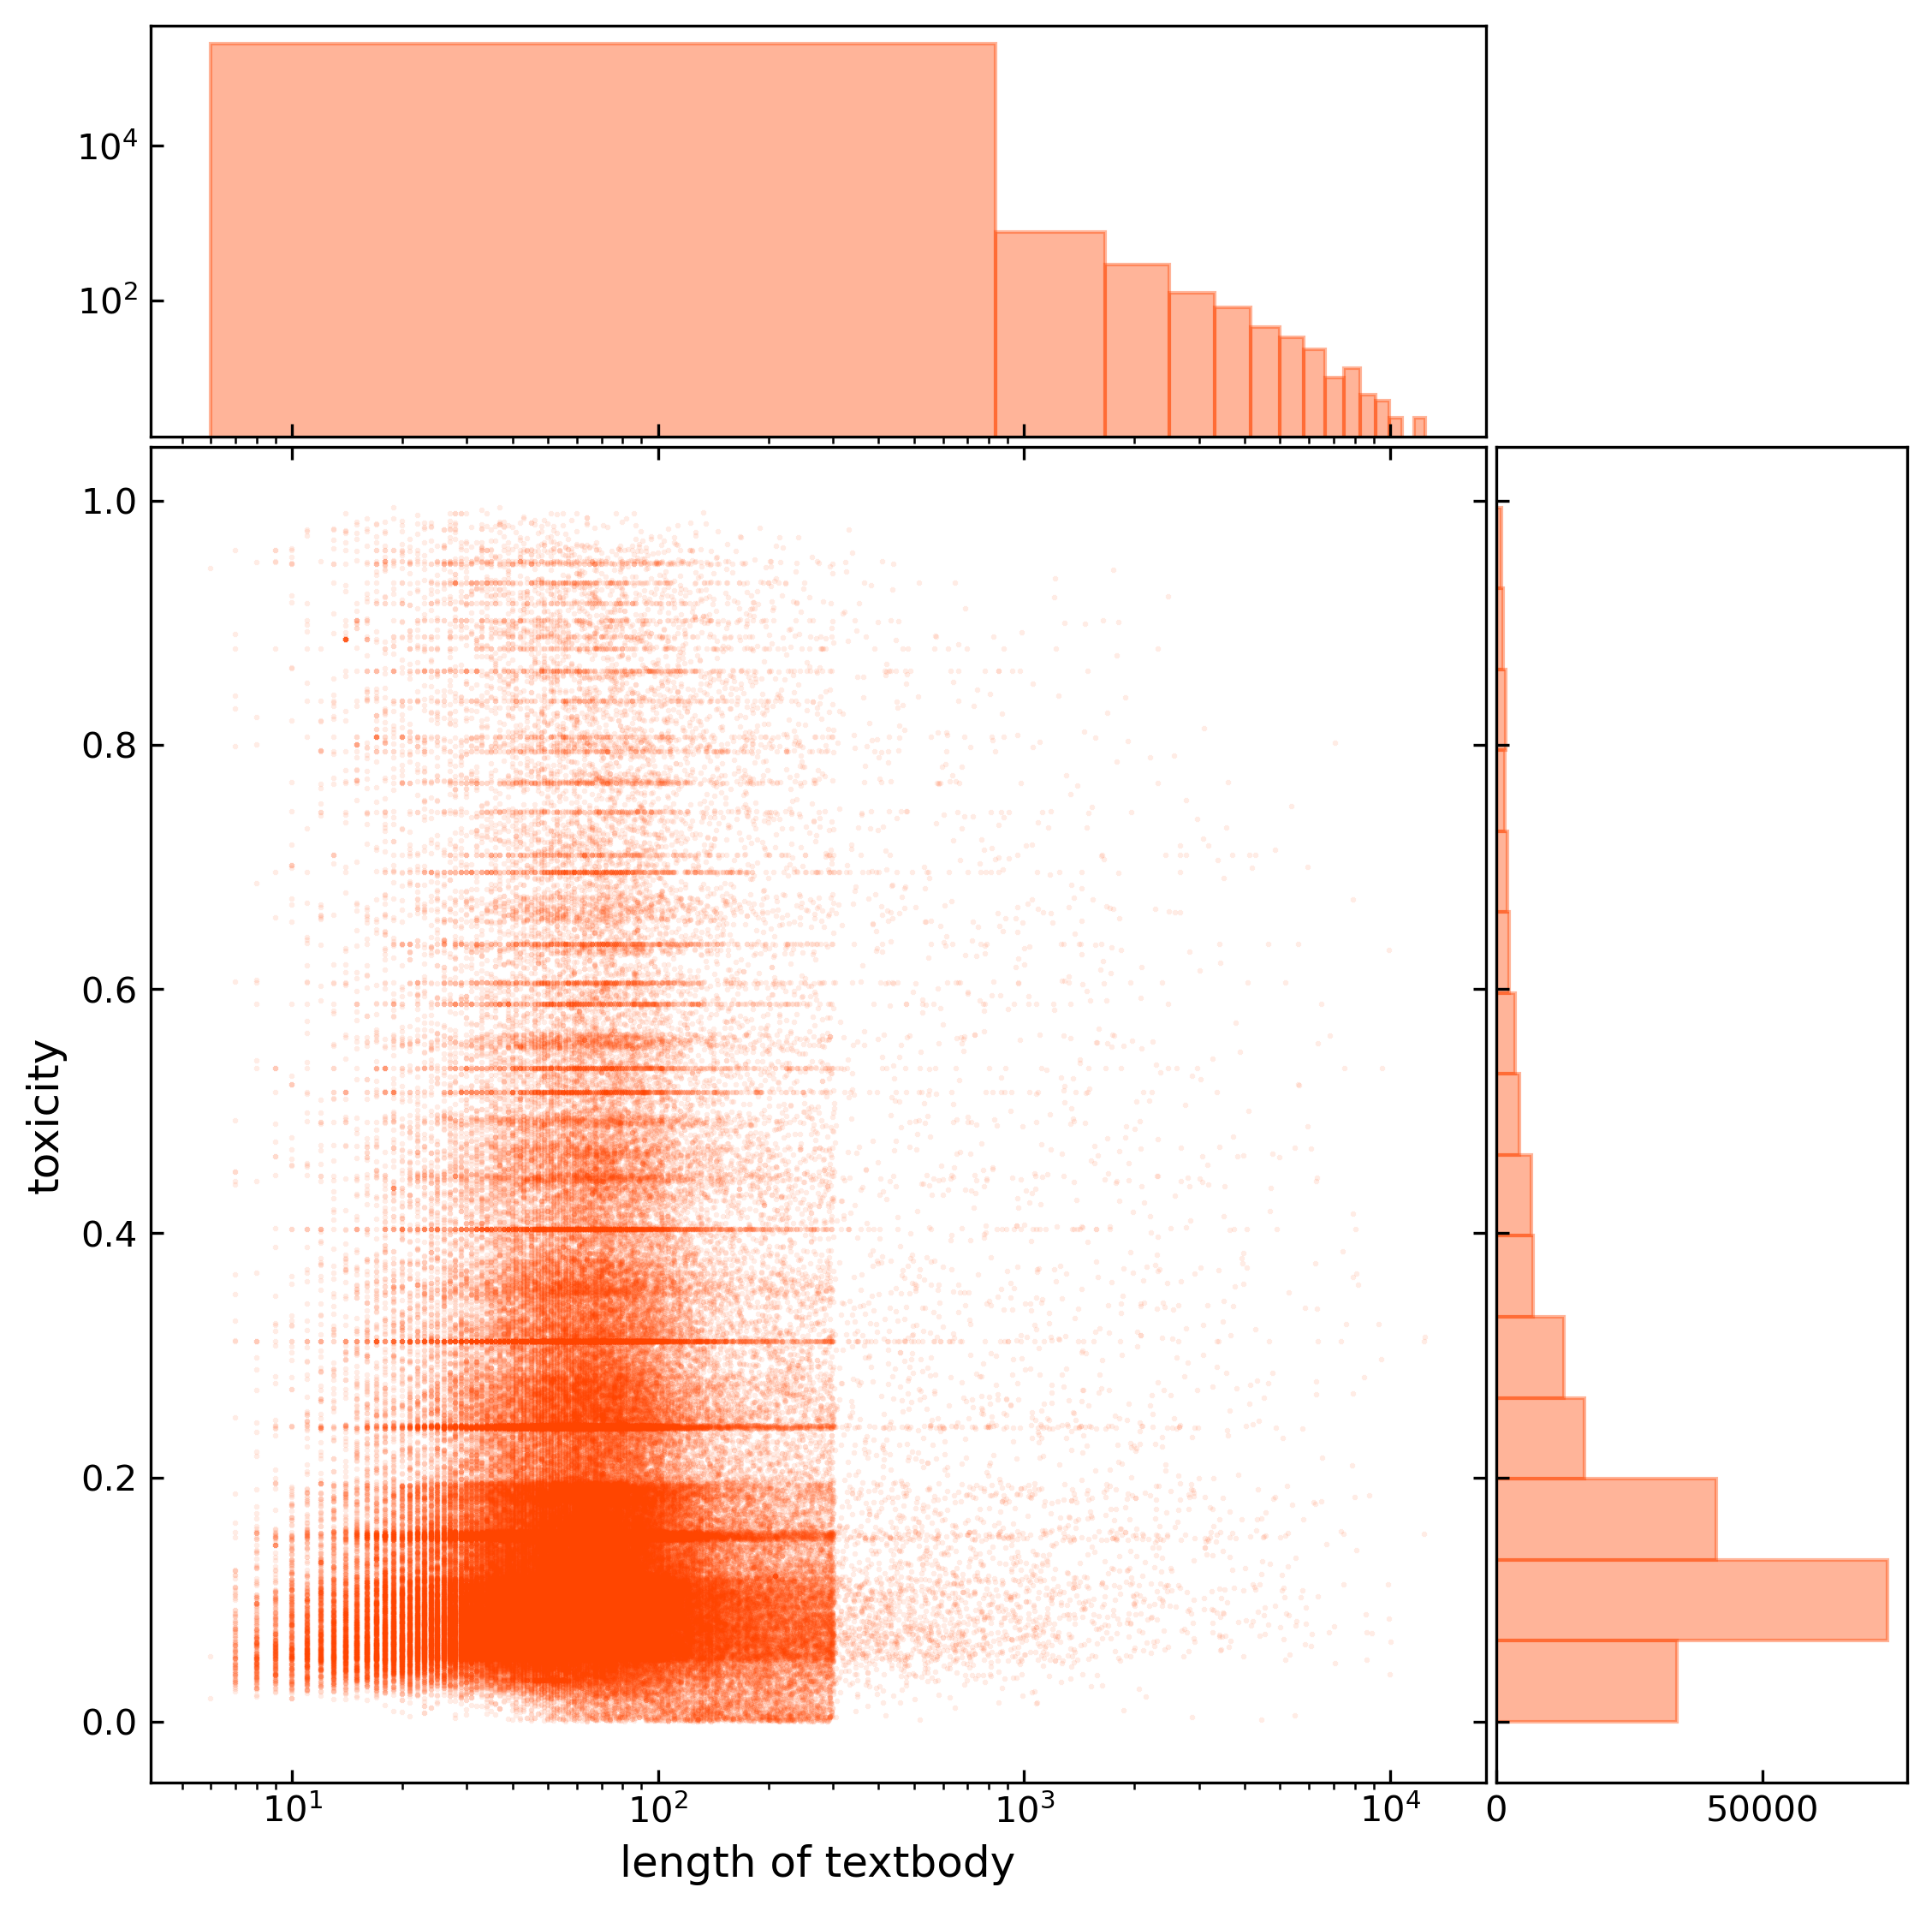

In [15]:
# docs: https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/scatter_hist.html
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

plotdf = no_comment_subm.dropna(subset=["toxicity"])
x = plotdf["body_len"]
y = plotdf["toxicity"]

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

plt.figure(figsize=(8,8), dpi=300)

# scatterplot
ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction="in", top=True, right=True)
ax_scatter.set_xscale("log")
ax_scatter.scatter(x, y, color="#FF4500", marker="+", s=1, alpha=0.1)
# plt.hist2d(x, y, (80,80), cmap="Reds")
ax_scatter.set_xlabel("length of textbody", fontsize=12)
ax_scatter.set_ylabel("toxicity", fontsize=12)

# histogram
ax_histx = plt.axes(rect_histx)
ax_histx.set_xscale("log")
ax_histx.set_yscale("log")
ax_histx.tick_params(direction="in", labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction="in", labelleft=False)
ax_histx.hist(x, bins=15, color="#FF4500", ec="#FF4500", alpha=0.4)
ax_histy.hist(y, orientation="horizontal", bins=15, color="#FF4500", ec="#FF4500", alpha=0.4)

plt.savefig(ROOTPATH + "output/fig/toxicity_length.png", dpi=300)

## build trees

In [33]:
df2012_with_comm = df2012[["submission_id","comment_id", "parent_id"]].dropna()
aggr_func = {"comment_id":lambda x: list(x)}
groupby_subm = df2012_with_comm.groupby("submission_id").agg(aggr_func)
SUBM_COMM_DICT = groupby_subm.to_dict()["comment_id"]
COMM_PARENT_DICT = df2012_with_comm[["comment_id","parent_id"]].set_index("comment_id").to_dict()["parent_id"]

In [34]:
def build_tree_graph(subm):
    g = nx.DiGraph()
    comments = SUBM_COMM_DICT[subm]
    for comm in comments:
        its_parent = COMM_PARENT_DICT[comm][3:]
        g.add_edge(comm, its_parent)
    return g

In [35]:
ALL_SUBM = groupby_subm.index
SUBM_TREE_DICT = {}
for i,subm in enumerate(ALL_SUBM):
    if i%5000==0: print("progress:", i/len(ALL_SUBM))
    SUBM_TREE_DICT[subm] = build_tree_graph(subm)

progress: 0.0
progress: 0.019133116746451764
progress: 0.03826623349290353
progress: 0.05739935023935529
progress: 0.07653246698580705
progress: 0.09566558373225882
progress: 0.11479870047871057
progress: 0.13393181722516234
progress: 0.1530649339716141
progress: 0.17219805071806588
progress: 0.19133116746451764
progress: 0.2104642842109694
progress: 0.22959740095742115
progress: 0.24873051770387292
progress: 0.2678636344503247
progress: 0.2869967511967765
progress: 0.3061298679432282
progress: 0.32526298468967996
progress: 0.34439610143613175
progress: 0.3635292181825835
progress: 0.3826623349290353
progress: 0.401795451675487
progress: 0.4209285684219388
progress: 0.44006168516839056
progress: 0.4591948019148423
progress: 0.4783279186612941
progress: 0.49746103540774583
progress: 0.5165941521541976
progress: 0.5357272689006494
progress: 0.5548603856471012
progress: 0.573993502393553
progress: 0.5931266191400046
progress: 0.6122597358864564
progress: 0.6313928526329082
progress: 0.650

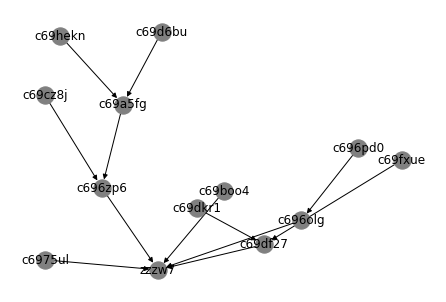

In [44]:
testg = build_tree_graph("zzzw7")
pos = nx.spring_layout(testg)
nx.draw(testg, pos, with_labels=True, node_color="grey")

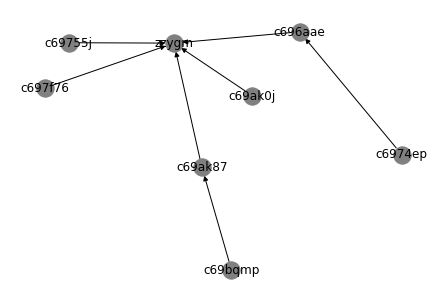

In [92]:
testg2 = build_tree_graph("zzygm") #'zzydm', 'zzygm', 'zzyhp', 'zzyrv', 'zzysf', 'zzz5k', 'zzzk6', 'zzzte'
pos = nx.spring_layout(testg2)
nx.draw(testg2, pos, with_labels=True, node_color="grey")

## calculate submission-level attributes

In [103]:
# toxicity, text length, number of unique authors
aggr_func = {"toxicity": [np.max, np.mean],
             "body_len": [np.sum, np.mean],
             "author": lambda x: set(x)}
groupby_subm = df2012.dropna(subset=["comment_id", "toxicity"]).groupby("submission_id").agg(aggr_func)
groupby_subm.columns = ["max_tox", "avg_tox", "sum_len", "avg_len", "authors"]
groupby_subm = groupby_subm.reset_index()
groupby_subm["n_authors"] = groupby_subm["authors"].map(lambda x: len(x))

In [105]:
from networkx.algorithms.dag import dag_longest_path
def get_depth(g):
    return len(dag_longest_path(g))
# get_depth(testg)  # 4

def get_breadth(g, root):
    return nx.degree(g, root)
# get_span(testg, "zzzw7")  # 5

def get_sv(g): # structural virality
    g2 = g.to_undirected().copy()
    nodes = g2.nodes()
    N = len(nodes)
    ds = []
    for nodepair in combinations(nodes, 2):
        d = nx.shortest_path_length(g2, source=nodepair[0], target=nodepair[1])
        ds.append(d)
    sv = np.sum(ds)/(N*(N-1))
    return sv
# get_sv(testg)  # 1.3974358974358974
# get_sv(testg2)  # 1.0535714285714286

In [119]:
depths = []
breadths = []
svs = []
unconnected = []
for i,row in groupby_subm.iterrows():
    if i%10000==0: print("progress:", i/len(groupby_subm))
    subm_id = row["submission_id"]
    this_tree = SUBM_TREE_DICT[subm_id]
    if nx.is_connected(this_tree.to_undirected()):
        depths.append(get_depth(this_tree))
        breadths.append(get_breadth(this_tree, subm_id))
        svs.append(get_sv(this_tree))
    else:
        depths.append(np.NaN)
        breadths.append(np.NaN)
        svs.append(np.NaN)

progress: 0.0
progress: 0.039765226105075636
progress: 0.07953045221015127
progress: 0.1192956783152269
progress: 0.15906090442030255
progress: 0.19882613052537818
progress: 0.2385913566304538
progress: 0.27835658273552943
progress: 0.3181218088406051
progress: 0.3578870349456807
progress: 0.39765226105075635
progress: 0.43741748715583195
progress: 0.4771827132609076
progress: 0.5169479393659833
progress: 0.5567131654710589
progress: 0.5964783915761345
progress: 0.6362436176812102
progress: 0.6760088437862858
progress: 0.7157740698913614
progress: 0.755539295996437
progress: 0.7953045221015127
progress: 0.8350697482065883
progress: 0.8748349743116639
progress: 0.9146002004167396
progress: 0.9543654265218152
progress: 0.9941306526268908


In [121]:
groupby_subm["depth"] = depths
groupby_subm["breadth"] = breadths
groupby_subm["sv"] = svs

In [201]:
# groupby_subm["n_authors_logged"] = groupby_subm["n_authors"].map(lambda x: np.log10(x))
# groupby_subm["depth_logged"] = groupby_subm["depth"].map(lambda x: np.log10(x))
# groupby_subm["breadth_logged"] = groupby_subm["breadth"].map(lambda x: np.log10(x))
# groupby_subm["sv_logged"] = groupby_subm["sv"].map(lambda x: np.log10(x))
# groupby_subm["sum_len_logged"] = groupby_subm["sum_len"].map(lambda x: np.log10(x))
# groupby_subm["avg_len_logged"] = groupby_subm["avg_len"].map(lambda x: np.log10(x))

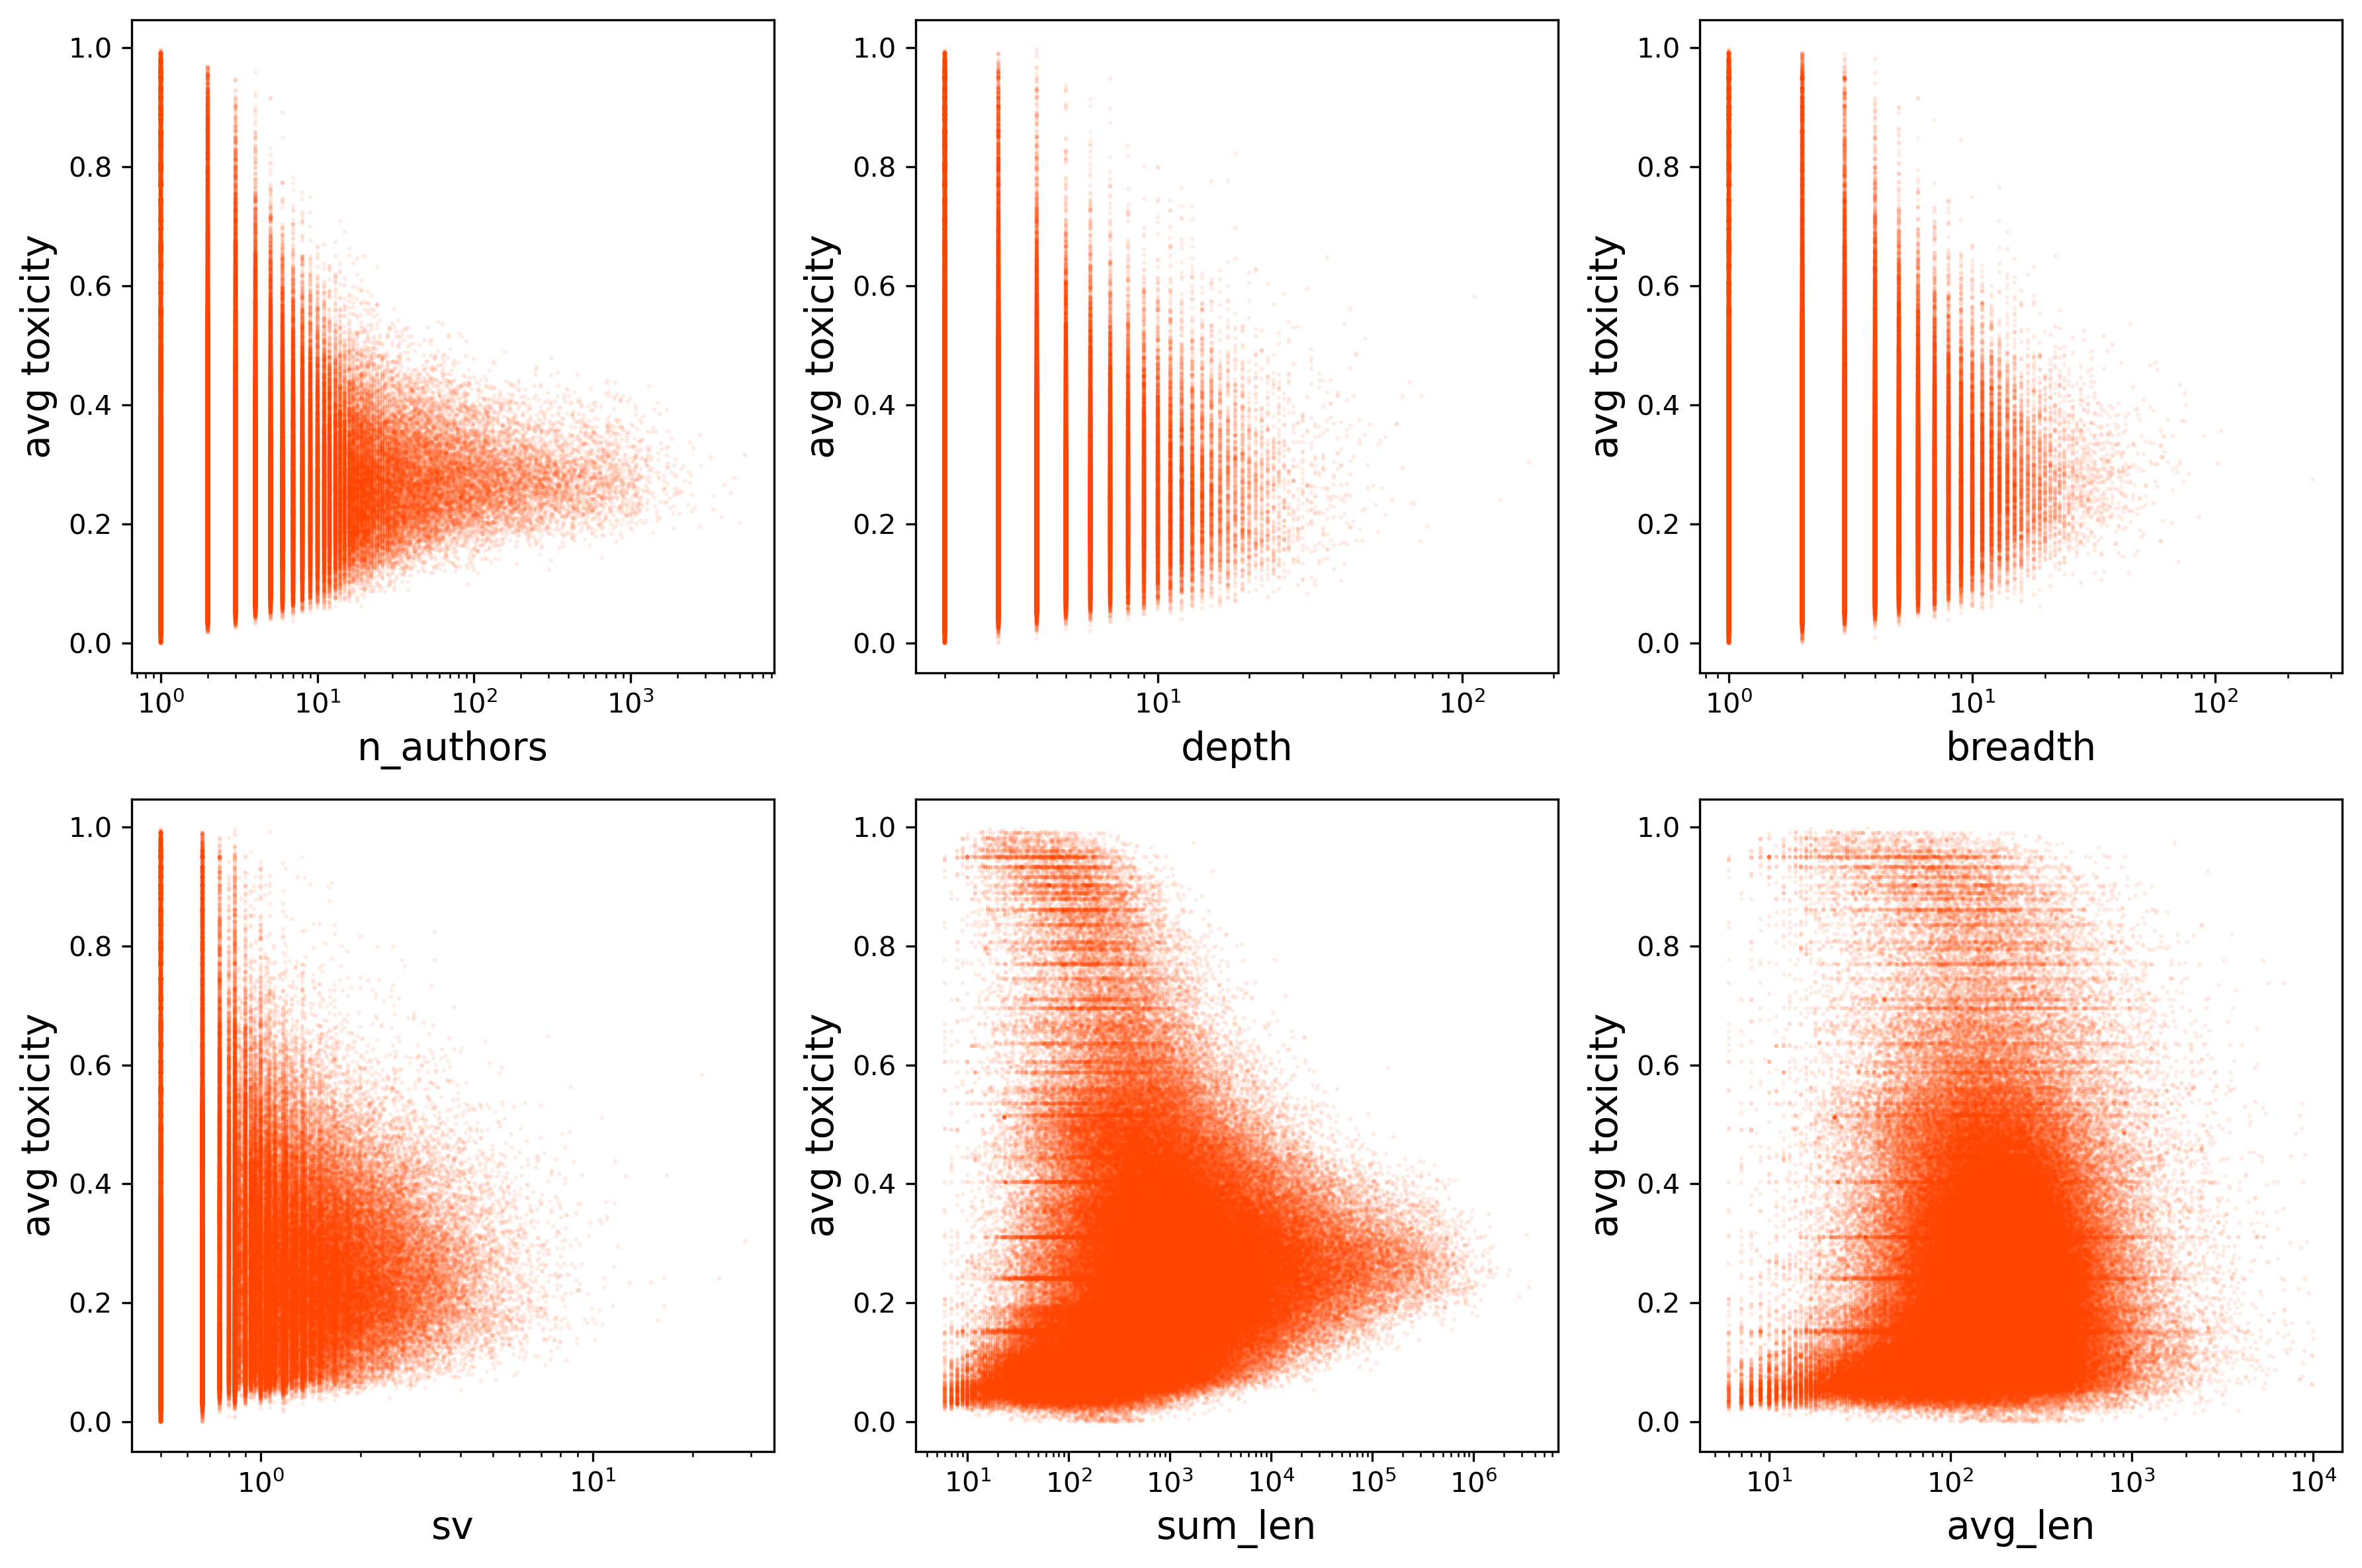

In [229]:
cols = ["n_authors","depth","breadth","sv", "sum_len", "avg_len"]
# plotdf = groupby_subm.dropna(subset=cols+["avg_tox"])
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(12,8), dpi=300)
ax = [x for ls in ax for x in ls]
for i,col in enumerate(cols):
#     print(col)
    plotdf = groupby_subm.dropna(subset=["avg_tox", col])
    plotdf = plotdf[pd.to_numeric(plotdf[col], errors="coerce").notnull()]
    x = plotdf[col]
    y = plotdf["avg_tox"]
    # scatterplot
    _ = ax[i].scatter(x, y, cmap="Reds", alpha=0.1, s=1, marker="+", color="#FF4500")
#     ax[i].hist2d(x, y, (80,80), cmap="Reds")
    ax[i].set_xscale("log")
    ax[i].set_xlabel(col, fontsize=14)
    ax[i].set_ylabel("avg toxicity", fontsize=14)
    
fig.tight_layout() 
plt.savefig(ROOTPATH + f"output/fig/avg_tox_subm_metrics_scatter.png", dpi=300)

In [230]:
# corrdf = plotdf[["avg_tox","sum_len","avg_len","n_authors","depth", "breadth", "sv"]].dropna()
# corrdf = corrdf[pd.to_numeric(corrdf["breadth"], errors="coerce").notnull()]
# corrdf["breadth"] = corrdf["breadth"].map(lambda x: float(x))
# corr = corrdf.corr()
# corr.style.background_gradient(cmap="Reds")

## RF classifier

In [247]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, chi2, f_classif

In [262]:
rf_df = plotdf[["n_authors","depth","breadth","sv","avg_len","avg_tox"]].dropna()
rf_df = rf_df[pd.to_numeric(rf_df["breadth"], errors="coerce").notnull()]
X = rf_df.drop(columns=["avg_tox"]).values
y = rf_df["avg_tox"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1944, test_size=0.25)

In [275]:
param_grid = [{"n_estimators": [5, 10, 100, 1000]}]
pipe = Pipeline([("reg", RandomForestRegressor())])
param_grid = [{"reg__n_estimators": np.arange(5, 30, 5),
               "reg__max_depth": np.arange(2, 5, 1)]
#                "reg__criterion": ["mse", "mae"]}]  

In [ ]:
rf = RandomForestRegressor(n_estimators=5, max_depth=5, criterion="mae")
rf.fit(X_train, y_train)

In [276]:
search = GridSearchCV(pipe, param_grid, cv=5, verbose=2)
search.fit(X_train, y_train)
print(f"best parameter: {search.best_params_}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] reg__criterion=squared_error, reg__max_depth=2, reg__n_estimators=5 
[CV]  reg__criterion=squared_error, reg__max_depth=2, reg__n_estimators=5, total=   0.2s
[CV] reg__criterion=squared_error, reg__max_depth=2, reg__n_estimators=5 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  reg__criterion=squared_error, reg__max_depth=2, reg__n_estimators=5, total=   0.1s
[CV] reg__criterion=squared_error, reg__max_depth=2, reg__n_estimators=5 
[CV]  reg__criterion=squared_error, reg__max_depth=2, reg__n_estimators=5, total=   0.1s
[CV] reg__criterion=squared_error, reg__max_depth=2, reg__n_estimators=5 
[CV]  reg__criterion=squared_error, reg__max_depth=2, reg__n_estimators=5, total=   0.1s
[CV] reg__criterion=squared_error, reg__max_depth=2, reg__n_estimators=5 
[CV]  reg__criterion=squared_error, reg__max_depth=2, reg__n_estimators=5, total=   0.1s
[CV] reg__criterion=squared_error, reg__max_depth=2, reg__n_estimators=10 
[CV]  reg__criterion=squared_error, reg__max_depth=2, reg__n_estimators=10, total=   0.1s
[CV] reg__criterion=squared_error, reg__max_depth=2, reg__n_estimators=10 
[CV]  reg__criterion=squared_error, reg__max_depth=2, reg__n_estimators=10, total=   0.1s
[CV] reg__criterion=squared_error, reg__max_depth=2, reg__n_estimators=10 
[CV]  reg__criter

[CV]  reg__criterion=squared_error, reg__max_depth=4, reg__n_estimators=5, total=   0.1s
[CV] reg__criterion=squared_error, reg__max_depth=4, reg__n_estimators=5 
[CV]  reg__criterion=squared_error, reg__max_depth=4, reg__n_estimators=5, total=   0.1s
[CV] reg__criterion=squared_error, reg__max_depth=4, reg__n_estimators=5 
[CV]  reg__criterion=squared_error, reg__max_depth=4, reg__n_estimators=5, total=   0.1s
[CV] reg__criterion=squared_error, reg__max_depth=4, reg__n_estimators=10 
[CV]  reg__criterion=squared_error, reg__max_depth=4, reg__n_estimators=10, total=   0.1s
[CV] reg__criterion=squared_error, reg__max_depth=4, reg__n_estimators=10 
[CV]  reg__criterion=squared_error, reg__max_depth=4, reg__n_estimators=10, total=   0.1s
[CV] reg__criterion=squared_error, reg__max_depth=4, reg__n_estimators=10 
[CV]  reg__criterion=squared_error, reg__max_depth=4, reg__n_estimators=10, total=   0.1s
[CV] reg__criterion=squared_error, reg__max_depth=4, reg__n_estimators=10 
[CV]  reg__crit

[CV]  reg__criterion=absolute_error, reg__max_depth=3, reg__n_estimators=5, total=   0.1s
[CV] reg__criterion=absolute_error, reg__max_depth=3, reg__n_estimators=5 
[CV]  reg__criterion=absolute_error, reg__max_depth=3, reg__n_estimators=5, total=   0.1s
[CV] reg__criterion=absolute_error, reg__max_depth=3, reg__n_estimators=10 
[CV]  reg__criterion=absolute_error, reg__max_depth=3, reg__n_estimators=10, total=   0.1s
[CV] reg__criterion=absolute_error, reg__max_depth=3, reg__n_estimators=10 
[CV]  reg__criterion=absolute_error, reg__max_depth=3, reg__n_estimators=10, total=   0.1s
[CV] reg__criterion=absolute_error, reg__max_depth=3, reg__n_estimators=10 
[CV]  reg__criterion=absolute_error, reg__max_depth=3, reg__n_estimators=10, total=   0.1s
[CV] reg__criterion=absolute_error, reg__max_depth=3, reg__n_estimators=10 
[CV]  reg__criterion=absolute_error, reg__max_depth=3, reg__n_estimators=10, total=   0.1s
[CV] reg__criterion=absolute_error, reg__max_depth=3, reg__n_estimators=10 
[

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   12.0s finished


KeyError: 'squared_error'